In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV

import xgboost as xgb

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
# Read data from csv
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

train_df.drop('Id',axis=1,inplace=True)
test_df.drop('Id',axis=1,inplace=True)
print(train_df.shape)
print(test_df.shape)

(1460, 80)
(1459, 79)


In [4]:
# Remove outliers
train_df[train_df['GrLivArea']>4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


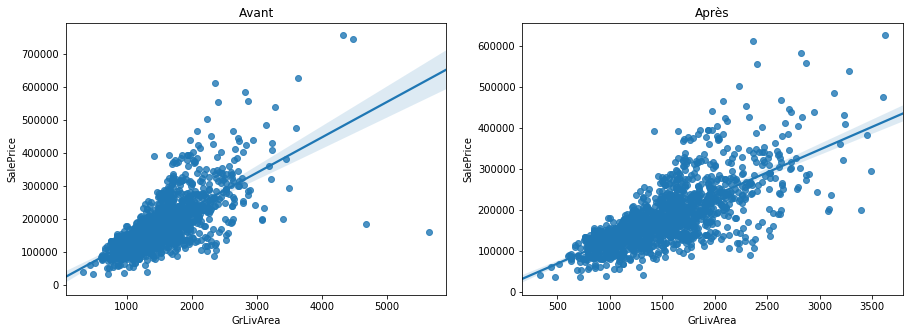

In [5]:
# Much better 
plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
g = sns.regplot(x=train_df['GrLivArea'],y=train_df['SalePrice'],fit_reg=True).set_title("Avant")

plt.subplot(1,2,2)
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000)].index)
g = sns.regplot(x=train_df['GrLivArea'],y=train_df['SalePrice'],fit_reg=True).set_title("Après")

In [6]:
# Remove outliers
train_df[train_df['LotArea']>70000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000


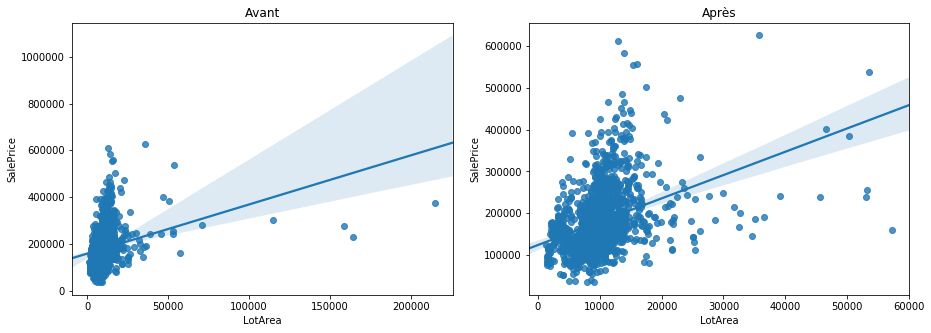

In [7]:
# Remove more would be better ? 
plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
g = sns.regplot(x=train_df['LotArea'],y=train_df['SalePrice'],fit_reg=True).set_title("Avant")

plt.subplot(1,2,2)
train_df = train_df.drop(train_df[(train_df['LotArea']>70000)].index)
g = sns.regplot(x=train_df['LotArea'],y=train_df['SalePrice'],fit_reg=True).set_title("Après")

In [8]:
train_num = train_df.shape[0]

In [9]:
# Treat the training set and test set in one time 
all_df = pd.concat((train_df, test_df)).reset_index(drop=True)
all_df.drop(['SalePrice'],axis=1,inplace=True)
all_df.shape

(2910, 79)

In [10]:
# Solve the NA probleme 
all_df_na = all_df.isnull().sum()
all_df_na = all_df_na.drop(all_df_na[all_df_na == 0].index).sort_values(ascending=False)

In [11]:
all_df_na

PoolQC          2902
MiscFeature     2807
Alley           2712
Fence           2340
FireplaceQu     1420
LotFrontage      483
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

In [12]:
for i in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish","GarageType", 
          "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2", "MasVnrType", "MSSubClass"):
    all_df[i] = all_df[i].fillna("None")

for j in ("GarageYrBlt", "MasVnrArea", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF", 
          "TotalBsmtSF", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2"):
    all_df[j] = all_df[j].fillna(0)

all_df["LotFrontage"] = all_df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_df['MSZoning'] = all_df['MSZoning'].fillna(all_df['MSZoning'].mode()[0])
all_df['Utilities'] = all_df['Utilities'].fillna(all_df['Utilities'].mode()[0])
all_df["Functional"] = all_df["Functional"].fillna(all_df['Functional'].mode()[0])
all_df['Electrical'] = all_df['Electrical'].fillna(all_df['Electrical'].mode()[0])
all_df['Exterior1st'] = all_df['Exterior1st'].fillna(all_df['Exterior1st'].mode()[0])
all_df['Exterior2nd'] = all_df['Exterior2nd'].fillna(all_df['Exterior2nd'].mode()[0])
all_df['KitchenQual'] = all_df['KitchenQual'].fillna(all_df['KitchenQual'].mode()[0])
all_df['SaleType'] = all_df['SaleType'].fillna(all_df['SaleType'].mode()[0])

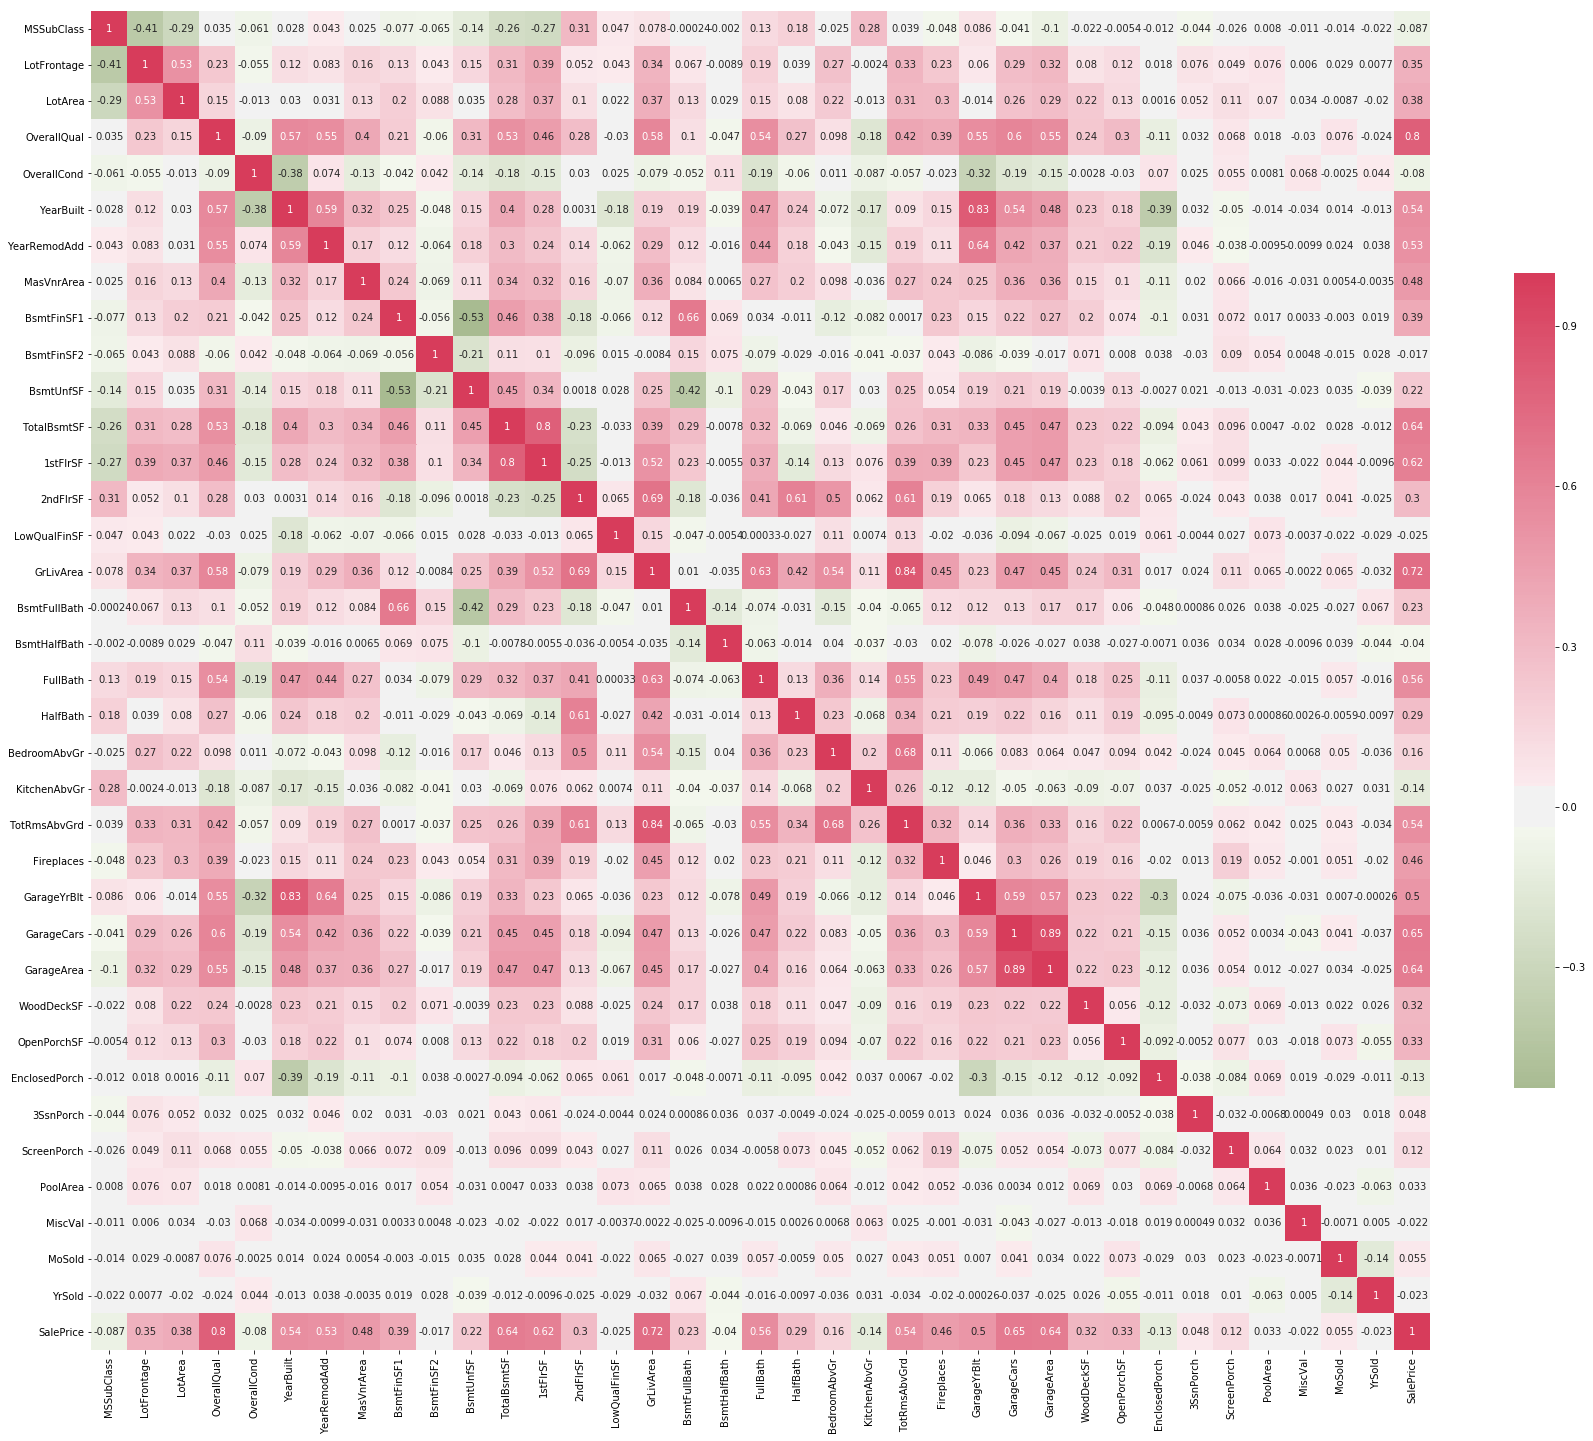

In [13]:
# Watch the correlation 
corrl_matrix = train_df.corr()

plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(110, 5, as_cmap=True)
sns.heatmap(corrl_matrix, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True) 

In [14]:
# Details of analysation omitted 
# Drop these features 
# number: 12
list_a_drop_1 = ["Street", "Utilities", "MiscFeature", "MiscVal", "MSSubClass", "RoofMatl", "MasVnrArea", "Condition2", 
               "PoolQC", "GarageCars", "GarageCond", "Exterior2nd"]

# number: 12
list_a_drop_2 = ["GarageType", "BsmtFinType2", "BsmtFinSF2", "Heating", "TotalBsmtSF", "GrLivArea", "LowQualFinSF", 
                 "MoSold", "YrSold", "PoolArea", "YearRemodAdd", "GarageYrBlt"]

In [15]:
all_df = all_df.drop(list_a_drop_1, axis=1)
all_df = all_df.drop(list_a_drop_2, axis=1)
all_df.shape

(2910, 55)

In [16]:
# Leave these features alone 
# number: 5
list_not_touch = ["BedroomAbvGr", "KitchenAbvGr", "Fireplaces", "OverallQual", "OverallCond"]

In [17]:
# Standardize these features 
# number: 10
list_a_standardize = ["TotRmsAbvGrd", "BsmtFinSF1", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "YearBuilt", "GarageArea", 
                      "WoodDeckSF", "LotFrontage", "LotArea"]
scaler = RobustScaler()

In [18]:
all_df["TotRmsAbvGrd"] = scaler.fit_transform(all_df["TotRmsAbvGrd"].values.reshape(len(all_df["TotRmsAbvGrd"]),1))
all_df["BsmtFinSF1"] = scaler.fit_transform(all_df["BsmtFinSF1"].values.reshape(len(all_df["BsmtFinSF1"]),1))
all_df["BsmtUnfSF"] = scaler.fit_transform(all_df["BsmtUnfSF"].values.reshape(len(all_df["BsmtUnfSF"]),1))
all_df["1stFlrSF"] = scaler.fit_transform(all_df["1stFlrSF"].values.reshape(len(all_df["1stFlrSF"]),1))
all_df["2ndFlrSF"] = scaler.fit_transform(all_df["2ndFlrSF"].values.reshape(len(all_df["2ndFlrSF"]),1))
all_df["YearBuilt"] = scaler.fit_transform(all_df["YearBuilt"].values.reshape(len(all_df["YearBuilt"]),1))
all_df["GarageArea"] = scaler.fit_transform(all_df["GarageArea"].values.reshape(len(all_df["GarageArea"]),1))
all_df["WoodDeckSF"] = scaler.fit_transform(all_df["WoodDeckSF"].values.reshape(len(all_df["WoodDeckSF"]),1))
all_df["LotFrontage"] = scaler.fit_transform(all_df["LotFrontage"].values.reshape(len(all_df["LotFrontage"]),1))
all_df["LotArea"] = scaler.fit_transform(all_df["LotArea"].values.reshape(len(all_df["LotArea"]),1))

In [19]:
# Combine these features of the same type together 
# Number: 8
list_add = ["BsmtHalfBath", "BsmtFullBath", "HalfBath", "FullBath","OpenPorchSF", "EnclosedPorch", 
            "3SsnPorch", "ScreenPorch"]

In [20]:
all_df['AllBaths'] = all_df['BsmtHalfBath'] + all_df['BsmtFullBath'] + all_df['HalfBath'] + all_df['FullBath']

all_df['AllPorchSF'] = all_df['OpenPorchSF'] + all_df['OpenPorchSF'] + all_df['EnclosedPorch'] + all_df['3SsnPorch'] + all_df['ScreenPorch'] 
all_df["AllPorchSF"] = scaler.fit_transform(all_df["AllPorchSF"].values.reshape(len(all_df["AllPorchSF"]),1))

all_df.drop(list_add, axis=1, inplace=True)
all_df.shape

(2910, 49)

In [24]:
# Change them to ordinal
# Number: 19
list_a_map = ["BsmtQual", "BsmtCond","BsmtExposure", "BsmtFinType1", "KitchenQual", "FireplaceQu", "Functional", "ExterQual", 
              "ExterCond", "GarageFinish", "Fence", "GarageQual", "LandSlope", "Alley", "PavedDrive", "HeatingQC", 
              "CentralAir", "Electrical", "LotShape"]

In [25]:
all_df['BsmtQual'] = all_df['BsmtQual'].map({'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
all_df['BsmtCond'] = all_df['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_df['BsmtExposure'] = all_df['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_df["BsmtFinType1"] = all_df["BsmtFinType1"].map({"None":0, "LwQ":1, "Rec":1, "BLQ":1, "ALQ":1, "Unf":2, "GLQ":3})
all_df['KitchenQual'] = all_df['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_df['FireplaceQu'] = all_df['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_df['Functional'] = all_df['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_df['ExterQual'] = all_df['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_df['ExterCond'] = all_df['ExterCond'].map({"Po":1, "Fa":1, "TA":2, "Gd":2, "Ex":2})
all_df['GarageFinish'] = all_df['GarageFinish'].map({"None":0, "Unf":1, "RFn":2, "Fin":3})
all_df['Fence'] = all_df['Fence'].map({"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4})
all_df['GarageQual'] = all_df['GarageQual'].map({"None":0, "Po":1, "Fa":1, "TA":2, "Gd":2, "Ex":2})
all_df['LandSlope'] = all_df['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})
all_df["Alley"] = all_df["Alley"].map({"None":0, "Grvl":1, "Pave":2})
all_df["PavedDrive"] = all_df["PavedDrive"].map({"N":1, "P":2, "Y":3})
all_df['HeatingQC'] = all_df['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_df['CentralAir'] = all_df['CentralAir'].map({"Y":1, "N":0})
all_df['Electrical'] = all_df['Electrical'].map({"SBrkr":2, "FuseF":1, "FuseA":1, "FuseP":1, "Mix":1})
all_df["LotShape"] = all_df["LotShape"].map({"Reg":1, "IR1":2, "IR2":2, "IR3":2 })

In [75]:
# Use one hot encoding 
# number: 13
list_a_dummy = ["BldgType", "HouseStyle", "Foundation", "MasVnrType", "RoofStyle", "Exterior1st", "MSZoning", "Neighborhood", 
               "Condition1", "LandContour", "LotConfig", "SaleType", "SaleCondition"]

In [29]:
all_df['BldgType'] = all_df['BldgType'].astype(str)
all_df = pd.get_dummies(all_df, columns = ["BldgType"], prefix="BldgType")
 
all_df['HouseStyle'] = all_df['HouseStyle'].map({"2.5Unf":"2.5Story", "2.5Fin":"2.5Story", "2Story":"2Story", 
                                                 "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", "1Story":"1Story", 
                                                 "SFoyer":"SFoyer", "SLvl":"SLvl" })
all_df = pd.get_dummies(all_df, columns = ["HouseStyle"], prefix="HouseStyle")

all_df['Condition1'] = all_df['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "Artery":"Street", 
                                                 "PosN":"Pos", "PosA":"Pos", "RRAe":"Train","RRNn":"Train", 
                                                 "RRAn":"Train", "RRNe":"Train"})
all_df = pd.get_dummies(all_df, columns = ["Condition1"], prefix="Condition1")

all_df['LotConfig'] = all_df['LotConfig'].map({"Inside":"Inside", "Corner":"Corner", "CulDSac":"CulDSac", 
                                                   "FR2":"FR", "FR3":"FR"})
all_df = pd.get_dummies(all_df, columns = ["LotConfig"], prefix="LotConfig")


all_df['SaleType'] = all_df['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", 
                                                 "ConLI":"Oth", "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})
all_df = pd.get_dummies(all_df, columns = ["SaleType"], prefix="SaleType")

all_df = pd.get_dummies(all_df, columns = ["Foundation"], prefix="Foundation")
all_df = pd.get_dummies(all_df, columns = ["MasVnrType"], prefix="MasVnrType")
all_df = pd.get_dummies(all_df, columns = ["RoofStyle"], prefix="RoofStyle")
all_df = pd.get_dummies(all_df, columns = ["Exterior1st"], prefix="Exterior1st")
all_df = pd.get_dummies(all_df, columns = ["MSZoning"], prefix="MSZoning")
all_df = pd.get_dummies(all_df, columns = ["Neighborhood"], prefix="Neighborhood")
all_df = pd.get_dummies(all_df, columns = ["LandContour"], prefix="LandContour")
all_df = pd.get_dummies(all_df, columns = ["SaleCondition"], prefix="SaleCondition")

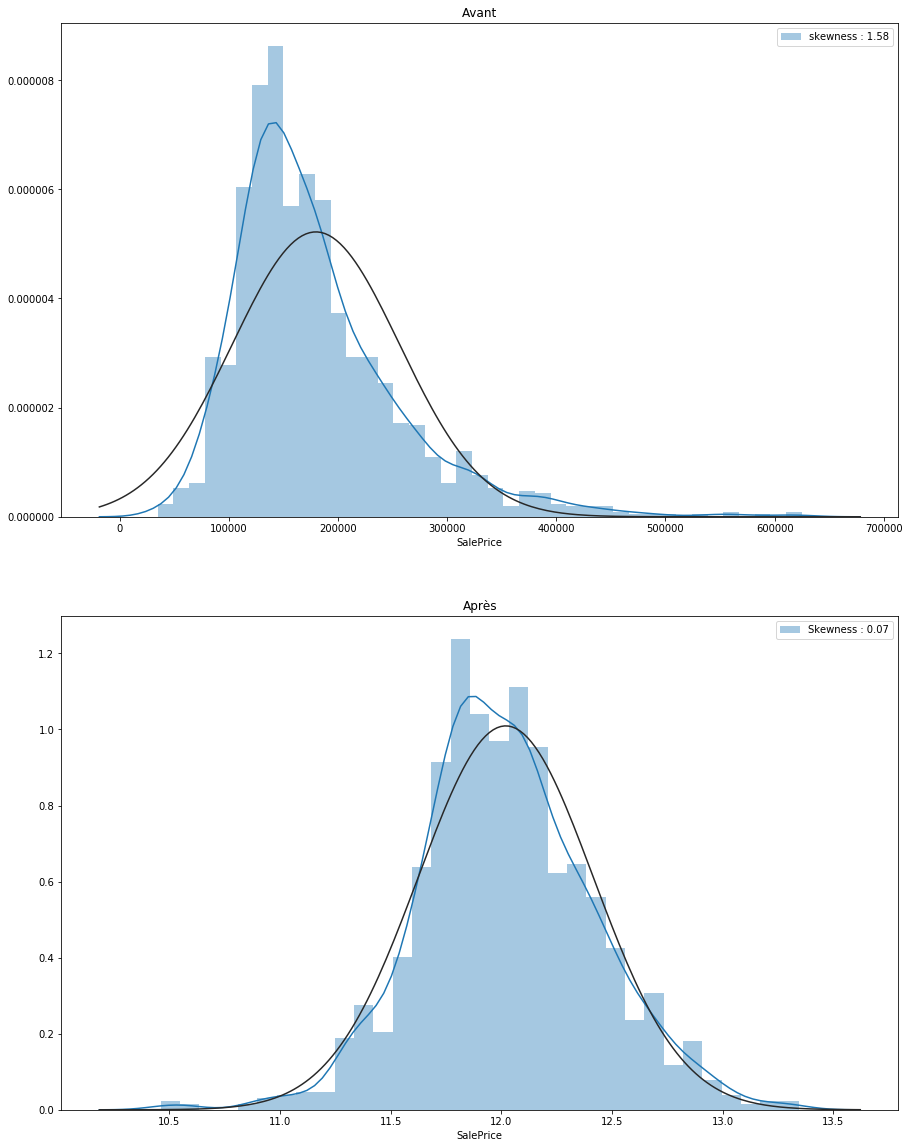

In [83]:
# Reduce the skewness of the target 
plt.subplots(figsize=(15,20))

plt.subplot(2,1,1)
g = sns.distplot(train_df['SalePrice'], fit=norm, label = "skewness : %.2f"%(train_df['SalePrice'].skew()))
g.set_title("Avant")
g = g.legend(loc="best")

plt.subplot(2,1,2)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
g = sns.distplot(train_df['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train_df['SalePrice'].skew()))
g.set_title("Après")
g = g.legend(loc="best")

In [90]:
train_label = train_df["SalePrice"]

In [106]:
pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

In [123]:
# Feature engineering finished, seperate train and test set
train = all_df[:train_num]
test = all_df[train_num:]

print(train.shape)
print(test.shape)

(1451, 131)
(1459, 131)


In [136]:
# Find feature importances
feature_selector = xgb.XGBRegressor()
feature_selector.fit(train, train_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [137]:
indices = np.argsort(feature_selector.feature_importances_)[::-1]

array([  0,   1,  29,  25,  28,  33,  18,   6,  35,   9,  34,  31,  78,
        17,  89,  32,  23, 129,   5, 122, 125,  66,   8,  86,   4,  87,
         3,  26,   2,  10,  41,  21, 105,  15, 108,  82, 110,  75, 117,
        36,  20,  90,  71,  27,  54, 128,  13,  47, 127,  76, 116,  81,
        80, 109,  30,  16, 102, 100,  19,  58,  11,  63,  14,  38,   7,
        49,  22, 130,  65,  97,  79, 123,  69, 119, 118,  98,  95, 101,
        99,  24,  96, 104,  94,  93,  92, 103, 107, 106,  88, 111,  12,
       112, 113, 114, 115, 120, 121, 124, 126,  91,  62,  85,  61,  60,
        59,  64,  57,  56,  55,  67,  53,  52,  51,  50,  68,  48,  46,
        45,  44,  43,  42,  70,  40,  39,  72,  37,  73,  74,  77,  83,  84])

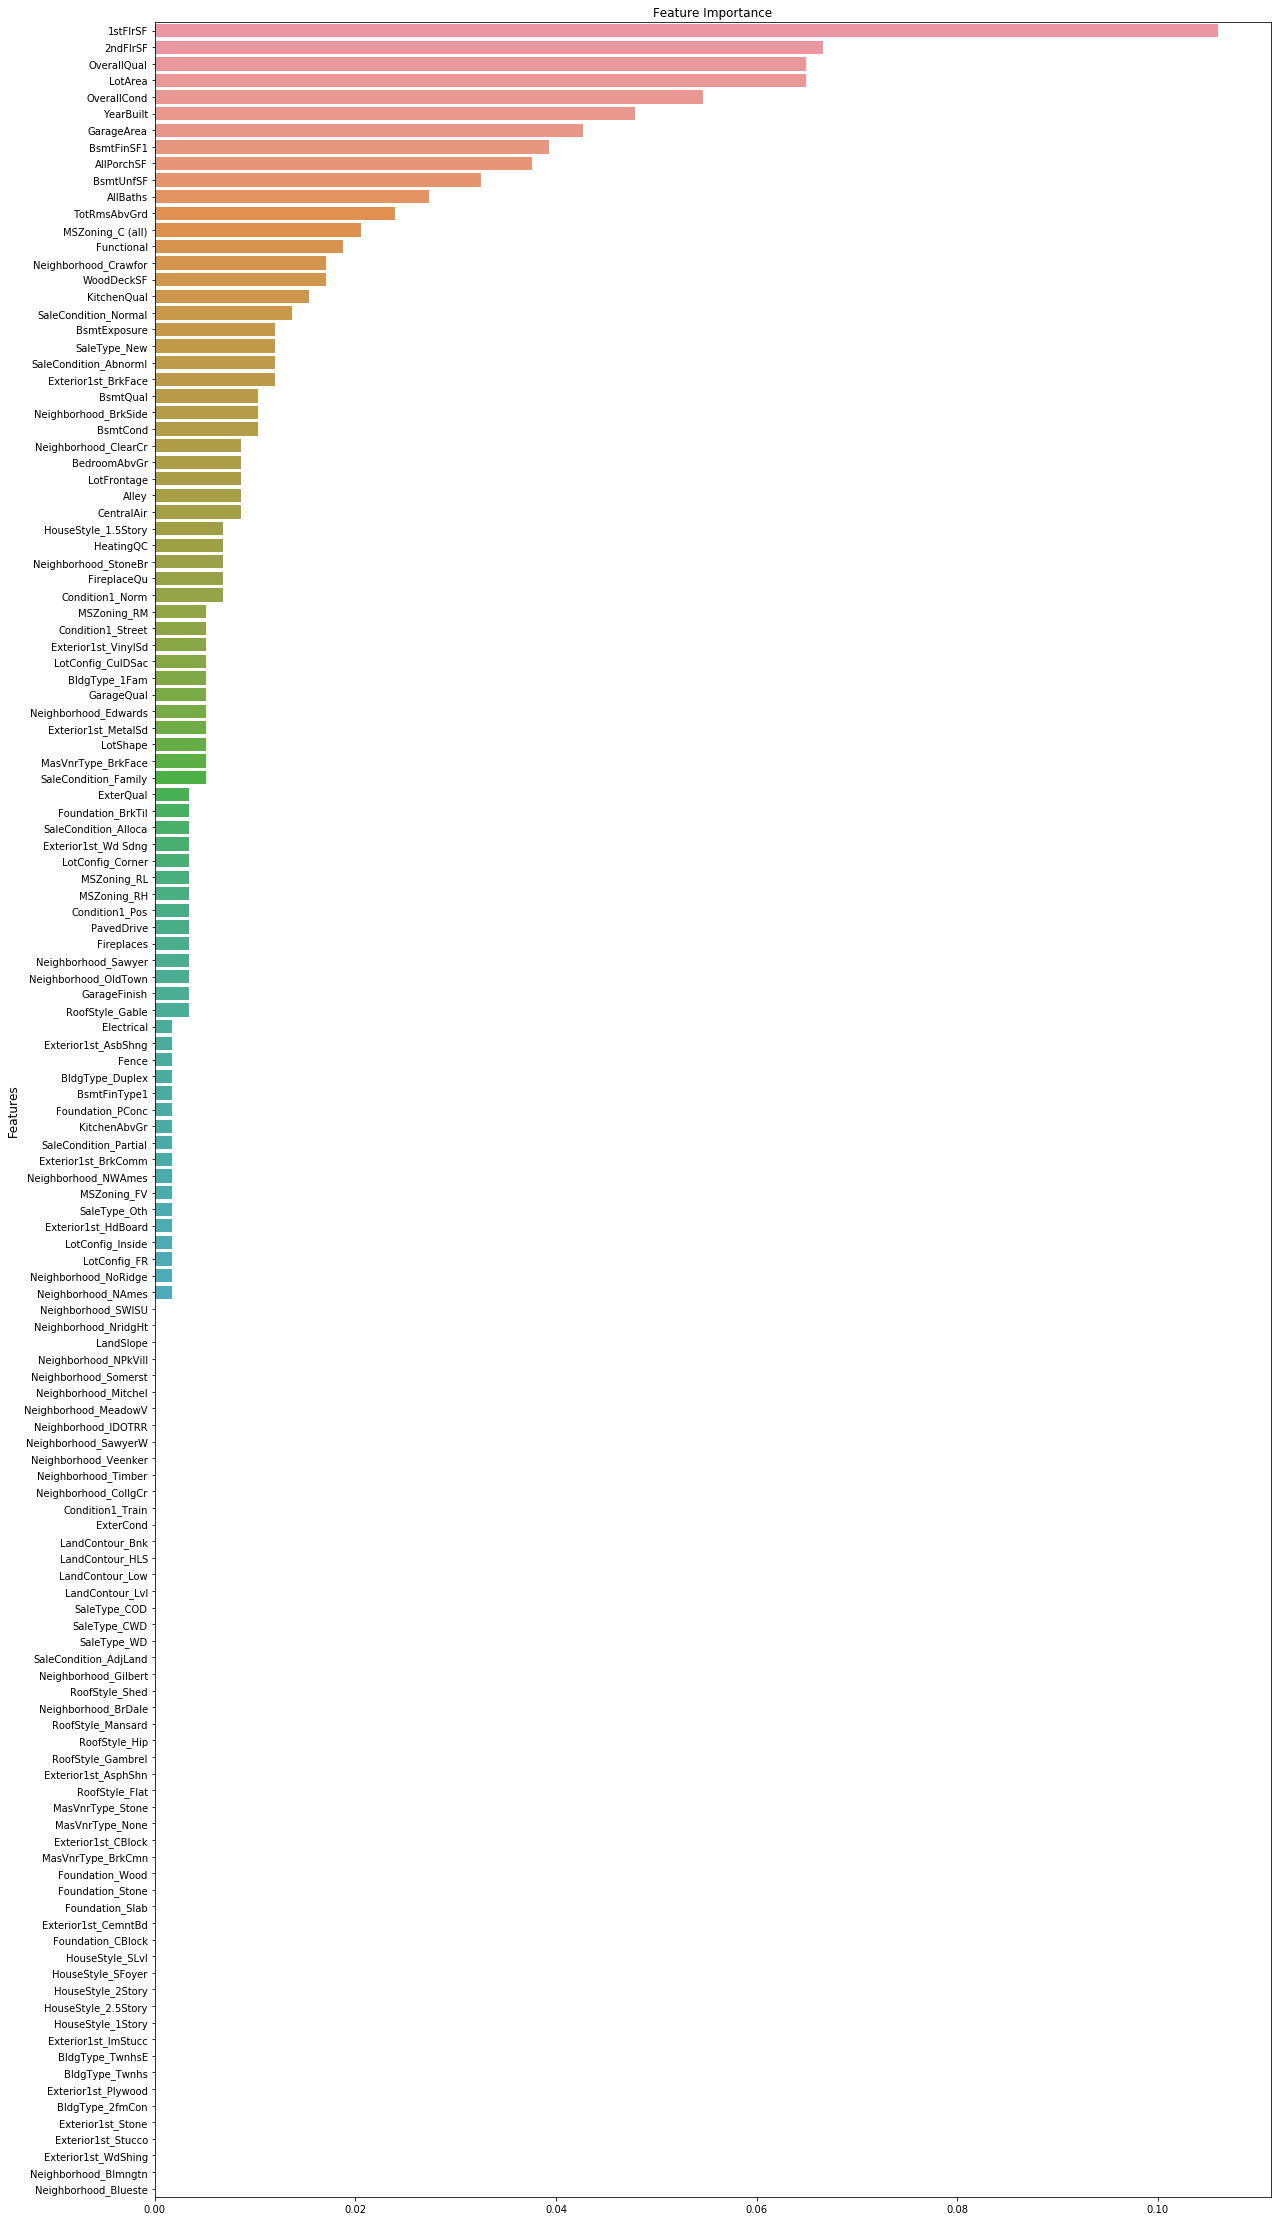

In [144]:
plt.subplots(figsize=(20, 40))
g = sns.barplot(y=train.columns[indices], x = feature_selector.feature_importances_[indices], orient='h')
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=10)
g.set_title("Feature Importance");

In [145]:
train_selected = train.copy()
test_selected = test.copy()

features_selected = SelectFromModel(feature_selector, prefit = True)

In [154]:
# Select features 
train_selected = features_selected.transform(train_selected)
test_selected = features_selected.transform(test_selected)

print(train_selected.shape)
print(test_selected.shape)

Results of 'feature_importances_':
X_train:  (1451, 30) 
X_test:  (1459, 30)


In [155]:
# Split training set to (test, validation) 
X_train, X_valid, Y_train, Y_valid =  train_test_split(train_selected, train_label, test_size=0.3, random_state=2018)
print('X_train: ', X_train.shape, '\nX_valid: ', X_valid.shape, '\nY_train: ', Y_train.shape, '\nY_valid: ', Y_valid.shape)

X_train:  (1015, 30) 
X_valid:  (436, 30) 
Y_train:  (1015,) 
Y_valid:  (436,)


In [ ]:
# Grid Search 

In [205]:
model = Lasso()
params = {'alpha': [ 0.0003, 0.001, 0.003, 0.01 ], 
          'max_iter': [ 100, 200, 300, 400, 500, 600 ], 
          'tol': [ 0.001, 0.003, 0.01, 0.03 ],
          'selection': ['random', 'cyclic']}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1, n_jobs=-1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

In [210]:
model = LassoLarsIC()
params = {'max_iter': [ 100, 200, 300 ], 
          'eps': [ 0.0000001, 0.0000003, 0.000001, 0.000003 ]}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished


LassoLarsIC(copy_X=True, criterion='aic', eps=1e-07, fit_intercept=True,
      max_iter=100, normalize=True, positive=False, precompute='auto',
      verbose=False)

In [213]:
model = KernelRidge()
params = {'alpha': [ 0.01, 0.03, 0.1, 0.3 ], 'degree': [1,2,3], 
          'kernel': ['linear', 'polynomial']}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   30.0s finished


KernelRidge(alpha=0.001, coef0=1, degree=1, gamma=None, kernel='polynomial',
      kernel_params=None)

In [219]:
model = BayesianRidge()
params = {'n_iter': [ 100, 200 ], 
          'tol': [ 0.0001, 0.0003, 0.001 ], 
          'alpha_1': [ 0.0000003, 0.000001, 0.000003, 0.00001 ], 
          'alpha_2': [ 0.00000003, 0.0000001, 0.0000003, 0.000001 ], 
          'lambda_1': [ 0.00000003, 0.0000001, 0.0000003, 0.000001 ], 
          'lambda_2': [ 0.0000003, 0.000001, 0.000003, 0.00001 ]}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:   23.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1500, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_iter': [100, 200], 'tol': [0.0001, 0.0003, 0.001], 'alpha_1': [3e-07, 1e-06, 3e-06, 1e-05], 'alpha_2': [3e-08, 1e-07, 3e-07, 1e-06], 'lambda_1': [3e-08, 1e-07, 3e-07, 1e-06], 'lambda_2': [3e-07, 1e-06, 3e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [227]:
model = ElasticNet()
params = {'alpha': [ 0.0001, 0.0003, 0.001, 0.003 ], 
          'l1_ratio': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ], 
          'max_iter': [ 100, 200, 300, 400, 500], 
          'tol': [ 0.001, 0.003, 0.01, 0.03], 
          'selection': ['random']}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/opt/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    4.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1500, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.0003, 0.001, 0.003], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'max_iter': [100, 200, 300, 400, 500], 'tol': [0.001, 0.003, 0.01], 'selection': ['random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [231]:
model = GradientBoostingRegressor()

params = {'loss': ['huber'], 
          'learning_rate': [ 0.001, 0.003, 0.1, 0.3 ], 
          'n_estimators': [ 100, 200, 300, 400, 500 ], 
          'max_depth': [ 2, 3, 4 ], 
          }

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1, n_jobs=-1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   47.6s finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=0.0025,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [233]:
model = RandomForestRegressor()

params = {'n_estimators': [20, 30, 40, 50, 60, 70 ], 
          'min_samples_split': [ 2, 3, 4, 5, 6, 7 ], 
          'min_samples_leaf': [ 1, 2, 3, 4 ]}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1, n_jobs=-1)
rslt.fit(X_train, Y_train)
rslt.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   29.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1500, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [235]:
model = xgb.XGBRegressor()

params = {'max_depth': [ 2, 3, 4, 5 ], 
          'learning_rate': [ 0.01, 0.03, 0.1, 0.3], 
          'n_estimators': [ 100, 200, 300, 400 ],
          'reg_alpha': [ 0.1, 0.3, 0.5, 0.7, 0.9 ], 
          'reg_lambda': [ 0.1, 0.3, 0.5, 0.7, 0.9 ], 
          'colsample_bytree': [ 0.1, 0.3, 0.5, 0.7, 0.9 ],  
          'colsample_bylevel': [ 0.1, 0.3, 0.5, 0.7, 0.9 ]}

shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1500)
rslt = GridSearchCV(model, param_grid = params, cv = shuffle, scoring = 'neg_mean_squared_error', verbose=1, n_jobs=-1)
rslt.fit(X_train, Y_train)
#rslt.best_estimator_

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 3896 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 5646 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 7896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 10646 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 13896 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 17646 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 21896 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 26646 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 31061 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 35661 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 40661 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 46061 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 51861 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 58061 tasks      |

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1500, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5], 'learning_rate': [0.01, 0.03, 0.1, 0.3], 'n_estimators': [100, 200, 300, 400], 'reg_alpha': [0.1, 0.3, 0.5, 0.7, 0.9], 'reg_lambda': [0.1, 0.3, 0.5, 0.7, 0.9], 'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9], 'colsample_bylevel': [0.1, 0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [236]:
rslt.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.3, reg_lambda=0.3, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [237]:
# Stacking 
LASSO_param = {'alpha': [0.0003],  'max_iter': [300], 'tol': [0.01], 'selection': ['random']}
LassoLarsIC_param = {'max_iter': [100], 'eps': [0.000001]}
KernelRidge_param = {'alpha': [0.01], 'degree': [1], 'kernel': ['polynomial']}
BayesianRidge_param = {'n_iter': [100], 'tol': [0.0003], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 
                       'lambda_1': [0.000005], 'lambda_2': [0.00000001]}
ElasticNet_param = {'alpha': [0.003], 'l1_ratio': [0.2], 'max_iter': [500], 'tol': [0.03], 'selection': ['random']}
GradientBoostingRegressor_param = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [400], 'max_depth': [3]}
RandomForestRegressor_param = {'n_estimators': [30], 'min_samples_split': [6], 'min_samples_leaf': [2]}
XGBRegressor_param = {'max_depth': [2], 'learning_rate': [0.1], 'n_estimators': [400], 'reg_alpha': [0.3], 
                      'reg_lambda': [0.3], 'colsample_bytree': [0.9], 'colsample_bylevel': [0.3]}

models = [ Lasso(), LassoLarsIC(), KernelRidge(), BayesianRidge(), ElasticNet(), GradientBoostingRegressor(), 
          RandomForestRegressor(), xgb.XGBRegressor()]
params = [LASSO_param, LassoLarsIC_param, KernelRidge_param, BayesianRidge_param, ElasticNet_param, 
               GradientBoostingRegressor_param, RandomForestRegressor_param, XGBRegressor_param]
shuffle = ShuffleSplit(n_splits=5, test_size=0.2, random_state=2018)

i=0
valid_stack_df = pd.DataFrame()
test_stack_df = pd.DataFrame()

for modl in models: 
    gscv = GridSearchCV(modl, param_grid = params[i], cv = shuffle, scoring = 'neg_mean_squared_error')
    gscv.fit(X_train, Y_train)
    best_estmtr = gscv.best_estimator_
    valid_stack_df.insert(loc = i, column = modl.__class__.__name__, value = best_estmtr.predict(X_valid))
    test_stack_df.insert(loc = i, column = modl.__class__.__name__, value = best_estmtr.predict(test_selected)) 
    i+=1

In [239]:
valid_stack_df.shape

(436, 8)

In [238]:
valid_stack_df.head()

,Lasso,LassoLarsIC,KernelRidge,BayesianRidge,ElasticNet,GradientBoostingRegressor,RandomForestRegressor,XGBRegressor
0,11.683284,11.681242,11.683087,11.684573,11.689990,11.751724,11.757258,11.748135
1,11.898841,11.900259,11.896381,11.897817,11.905875,11.868916,11.866079,11.857759
2,12.227819,12.230137,12.225039,12.226050,12.238356,12.247493,12.374567,12.230520
3,12.298790,12.294036,12.300764,12.299779,12.293282,12.319532,12.361848,12.280387
4,11.966650,11.975512,11.963578,11.963728,11.981482,11.882045,12.044512,11.906013


In [240]:
valid_stack_df.drop('Lasso', axis=1, inplace=True)
test_stack_df.drop('Lasso', axis=1, inplace=True)

In [242]:
StackLasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0001, max_iter = 10000, tol = 0.0001, selection = 'random'))
StackLasso.fit(valid_stack_df, Y_valid)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False))])

In [243]:
# Stacking result 
test_StackLasso = np.expm1(StackLasso.predict(test_stack_df))

In [249]:
# Ensembling 
modls = [ Lasso(), LassoLarsIC(), KernelRidge(), BayesianRidge(), ElasticNet(), GradientBoostingRegressor(), 
          RandomForestRegressor(), xgb.XGBRegressor()]
i=0
result = pd.DataFrame()

for modl in modls:
    gscv = GridSearchCV(modl, param_grid = params[i], cv = shuffle, scoring = 'neg_mean_squared_error')
    gscv.fit(valid_stack_df, Y_valid)
    best_estmtr = gscv.best_estimator_
    result.insert(loc = i, column = modl.__class__.__name__, value = np.expm1(best_estmtr.predict(test_stack_df)))
    i+=1

result.head()

,Lasso,LassoLarsIC,KernelRidge,BayesianRidge,ElasticNet,GradientBoostingRegressor,RandomForestRegressor,XGBRegressor
0,130171.210795,131368.690157,132315.739320,132531.002927,129466.858587,130632.791138,132983.480495,126034.632812
1,168256.502300,169868.534603,170018.943153,170117.620745,169419.952231,173196.196482,175255.029015,176237.875000
2,174400.492132,177560.367094,179805.612398,180274.373500,173097.456449,181615.158580,182205.642819,175279.609375
3,187295.686152,191003.083197,192021.024894,192426.577204,190134.507784,195143.741170,191554.632737,204681.578125
4,193561.543937,192989.930965,193014.304164,192750.082402,189958.744191,186463.802588,192113.485844,188803.265625


In [253]:
# Voting for the final submission result  
final_answer = ( result['XGBRegressor']*(2/10) + 
                result['RandomForestRegressor']*(1.5/10) +
                result['GradientBoostingRegressor']*(1.5/10) + 
                test_StackLasso*(1/10) + 
                result['BayesianRidge']*(1/10) + 
                result['Lasso']*(1/10) + 
                result['KernelRidge']*(1/10) + 
                result['LassoLarsIC']*(1/10) )                

In [273]:
'''
final_answer = ( result['XGBRegressor'] + result['RandomForestRegressor'] + result['GradientBoostingRegressor'] 
                + test_StackLasso + result['BayesianRidge'] + result['Lasso'] + result['KernelRidge'] + 
                result['LassoLarsIC'] ) / 8    
'''

In [275]:
subm_csv = pd.DataFrame()
subm_csv['Id'] = range(1461,2920)
subm_csv['SalePrice'] = final_answer
subm_csv.shape

(1459, 2)

In [276]:
subm_csv.to_csv('final_submission.csv',index=False)